# Detecting bird call activity in the audio samples

All training data is weakly labeled, providing a global label for a principal species in the recording, though there may be long periods where the labeled species does not occur. I preprocess the training datasets with an activity detector to select short windows that are likely to contain the labeled species for model training purposes. 

To choose a window, I create a log mel-spectrogram for each recording and compute the energy of each frame. I then apply a wavelet peak detector using `scipy` to find frames with high energy. I extract a 5-second window around each peak frame and select up to five windows in decreasing order of peak-frame energy. Resulting in 5 training samples for a given audio fragment. This process reliably finds the labeled species, but occasionally picks a background vocalization or human speech.

In [65]:
import pickle
import librosa
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Audio

sns.set(
    rc={
        "figure.figsize": (8, 3),
        "figure.dpi": 240,
    }
)
sns.set_style("darkgrid", {"axes.grid": False})
sns.set_context("paper", font_scale=0.6)


In [45]:
class cfg:
    root_folder = "../data"
    normalize_waveform = True
    sample_rate = 32000
    n_fft = 2048
    hop_length = 512
    window_length = None
    melspec_hres = 128
    melspec_wres = 312
    freq_min = 20
    freq_max = 16000
    log_scale_power = 3
    create_frames = True
    frame_duration = None
    max_decibels = 80
    frame_rate = sample_rate / hop_length

In [66]:
def load_data(path: str = cfg.root_folder) -> pd.DataFrame:
    model_input_df = pd.read_csv(
        f"{cfg.root_folder}/model_input_df.csv",
        dtype={
            "secondary_labels": "string",
            "primary_label": "category",
        },
    )

    return model_input_df


def create_log_melspec(
    path: np.ndarray,
    normalize: bool = cfg.normalize_waveform,
) -> np.ndarray:
    waveform, _ = librosa.load(path, sr=cfg.sample_rate, duration=cfg.frame_duration)

    if normalize:
        waveform = librosa.util.normalize(waveform)

    melspec = librosa.feature.melspectrogram(
        y=waveform,
        sr=cfg.sample_rate,
        n_fft=cfg.n_fft,
        hop_length=cfg.hop_length,
        n_mels=cfg.melspec_hres,
        fmin=cfg.freq_min,
        fmax=cfg.freq_max,
        power=cfg.log_scale_power,
    )

    melspec = librosa.power_to_db(melspec, ref=cfg.max_decibels)
    melspec = melspec - melspec.min()
    melspec = (melspec / melspec.max() * 255).astype(np.uint8)

    return melspec, waveform


def detect_train_activity_windows(melspec: np.ndarray) -> list:
    energy_per_frame = melspec.sum(axis=0)
    peak_idx = scipy.signal.find_peaks_cwt(
        energy_per_frame,
        widths=np.arange(20, 25),
        wavelet=None,
        max_distances=None,
        gap_thresh=None,
        min_length=1,
        min_snr=1.5,
        noise_perc=15,
        window_size=None,
    )

    if peak_idx.size == 0:  # if no peaks are detected take the first 5 seconds
        selected_windows = [[0, cfg.frame_rate * 5]]
    else:
        top_peaks = np.argsort(-energy_per_frame[peak_idx])[:5]
        top_peaks_idx = peak_idx[top_peaks]

        selected_windows = []
        for peak in top_peaks_idx:
            selected_windows.append(
                [peak - (cfg.frame_rate * 2.5), peak + (cfg.frame_rate * 2.5)]
            )

    return selected_windows, energy_per_frame, peak_idx


def visualize_train_activity_detection(
    model_input_df: pd.DataFrame, idx: int = None
) -> None:
    if idx is None:
        idx = np.random.randint(low=0, high=len(model_input_df))

    path = f"../data/train_audio/{model_input_df.loc[idx]['filename']}"

    audio = Audio(path)
    melspec, waveform = create_log_melspec(path=path)
    selected_windows, energy_per_frame, peak_idx = detect_train_activity_windows(melspec)

    fig, ax = plt.subplots(2, 1, sharex=True)
    sns.heatmap(melspec, ax=ax[0], cbar=False)

    for window in selected_windows:
        ax[1].axvspan(window[0], window[1], color="#F7C566", alpha=0.3)

    sns.lineplot(energy_per_frame, ax=ax[1], linewidth=0.5, color="#ef476f")
    sns.scatterplot(x=peak_idx, y=energy_per_frame[peak_idx], markers=".", color="#6C0345", ax=ax[1])

    ax[0].yaxis.set_visible(False)
    ax[1].yaxis.set_visible(False)
    ax[1].xaxis.set_visible(False)
    fig.suptitle(
        f"index: {idx}  |  "
        + f"label: {model_input_df.loc[idx]['primary_label']}  |  "
        + f"name: {model_input_df.loc[idx]['common_name']}  |  "
        + f"type: {model_input_df.loc[idx]['type']}  |  "
        + f"secondary: {model_input_df.loc[idx]['secondary_labels']}\n"
        + f"shape: {melspec.shape}  |  "
        + f"duration: {len(waveform) / cfg.sample_rate:.4}s  |  "
        + f"min: {melspec.min():.0f}, max: {melspec.max():.0f}  |  "
        + f"µ: {melspec.mean():.1f}, σ: {melspec.std():.1f}",
    )
    plt.tight_layout()
    plt.show()

    sns.lineplot(waveform, linewidth=0.5, color="#ef476f").yaxis.set_visible(False)
    for window in selected_windows:
        if window[0] < 0:
            window[0] = 0
        start = window[0] / cfg.frame_rate * cfg.sample_rate
        end = window[1] / cfg.frame_rate * cfg.sample_rate
        plt.axvspan(start, end, color="#F7C566", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return audio

In [81]:
model_input_df = load_data()
model_input_df.sample(10)

sample_index primary_label secondary_labels  \
16578          3651       blrwar1               []   
46991         10713       graher1               []   
68460         15507       junbab2               []   
12365          2738       blakit1               []   
25471          5699       comkin1               []   
57311         13106        grywag               []   
55474         12703       grtdro1               []   
45696         10411       graher1               []   
9101           2033        bkwsti               []   
59572         13614       gybpri1               []   

                                                    type  latitude  longitude  \
16578                                               ['']   52.0201     4.6196   
46991  ['life stage uncertain', 'nocturnal flight cal...   50.5795     8.6890   
68460                                               ['']   18.6496    73.7571   
12365                                           ['call']  -25.0336    46.2934   
25471                                  ['adult', 'call']   58.1658    12.9337   
57311                                   ['call', 'song']   33.2000   103.9000   
55474                                           ['call']   13.9144   104.5538   
45696              ['alarm call', 'call', 'flight call']   37.0951    -6.0386   
9101                    ['alarm call', 'female', 'male']   36.9020    -5.8975   
59572                                           ['call']   18.3759    73.7692   

              scientific_name                   common_name  \
16578  Acrocephalus dumetorum          Blyth's Reed Warbler   
46991           Ardea cinerea                    Gray Heron   
68460           Argya striata                Jungle Babbler   
12365          Milvus migrans                    Black Kite   
25471           Alcedo atthis             Common Kingfisher   
57311       Motacilla cinerea                  Gray Wagtail   
55474     Dicrurus paradiseus  Greater Racket-tailed Drongo   
45696           Ardea cinerea                    Gray Heron   
9101    Himantopus himantopus            Black-winged Stilt   
59572        Prinia hodgsonii          Gray-breasted Prinia   

                  author                                            license  \
16578       Michel Veldt  Creative Commons Attribution-NonCommercial-Sha...   
46991       Mona Kiepert  Creative Commons Attribution-NonCommercial-Sha...   
68460     Tushar Bhagwat  Creative Commons Attribution-NonCommercial-Sha...   
12365      Ross Gallardy  Creative Commons Attribution-NonCommercial-Sha...   
25471       Patrik Åberg  Creative Commons Attribution-NonCommercial-Sha...   
57311        Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...   
55474       Patrik Åberg  Creative Commons Attribution-NonCommercial-Sha...   
45696  José Carlos Sires  Creative Commons Attribution-NonCommercial-Sha...   
9101   José Carlos Sires  Creative Commons Attribution-NonCommercial-Sha...   
59572     Rajgopal Patil  Creative Commons Attribution-NonCommercial-Sha...   

       rating                                url              filename  \
16578     5.0      https://xeno-canto.org/770067  blrwar1/XC770067.ogg   
46991     4.0       http://xeno-canto.org/684993  graher1/XC684993.ogg   
68460     4.0      https://xeno-canto.org/789404  junbab2/XC789404.ogg   
12365     5.0  https://www.xeno-canto.org/418987  blakit1/XC418987.ogg   
25471     5.0  https://www.xeno-canto.org/511665  comkin1/XC511665.ogg   
57311     4.0  https://www.xeno-canto.org/266053   grywag/XC266053.ogg   
55474     5.0  https://www.xeno-canto.org/124360  grtdro1/XC124360.ogg   
45696     3.0  https://www.xeno-canto.org/299323  graher1/XC299323.ogg   
9101      3.0  https://www.xeno-canto.org/175409   bkwsti/XC175409.ogg   
59572     4.0  https://www.xeno-canto.org/576905  gybpri1/XC576905.ogg   

       n_frames species_code    species_order  \
16578         5      blrwar1    Passeriformes   
46991         5      graher1   Pelecaniform

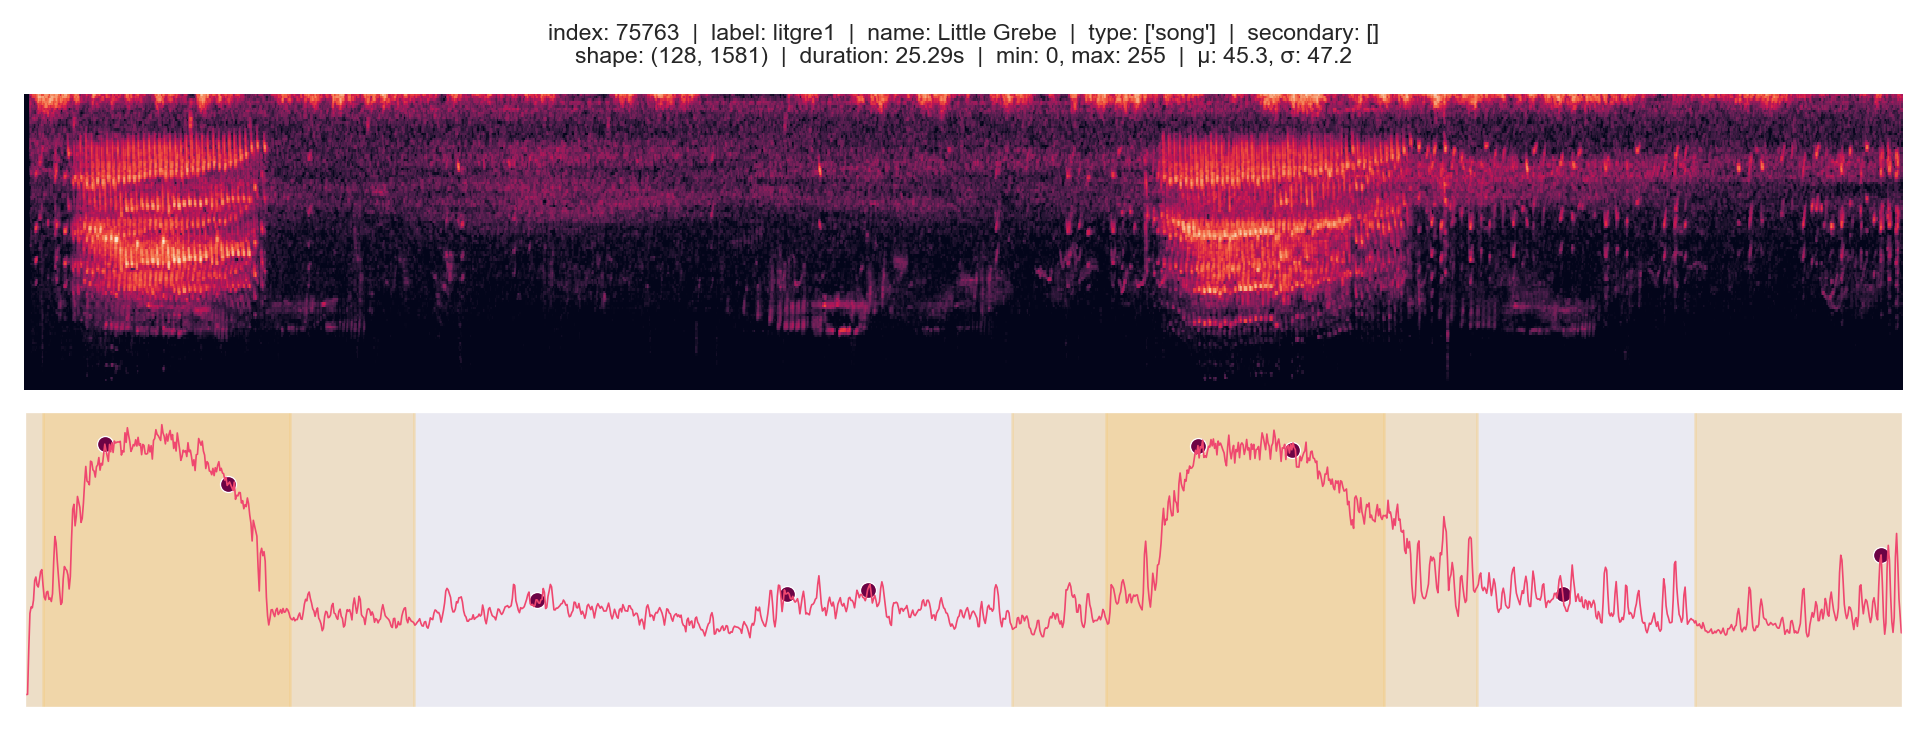

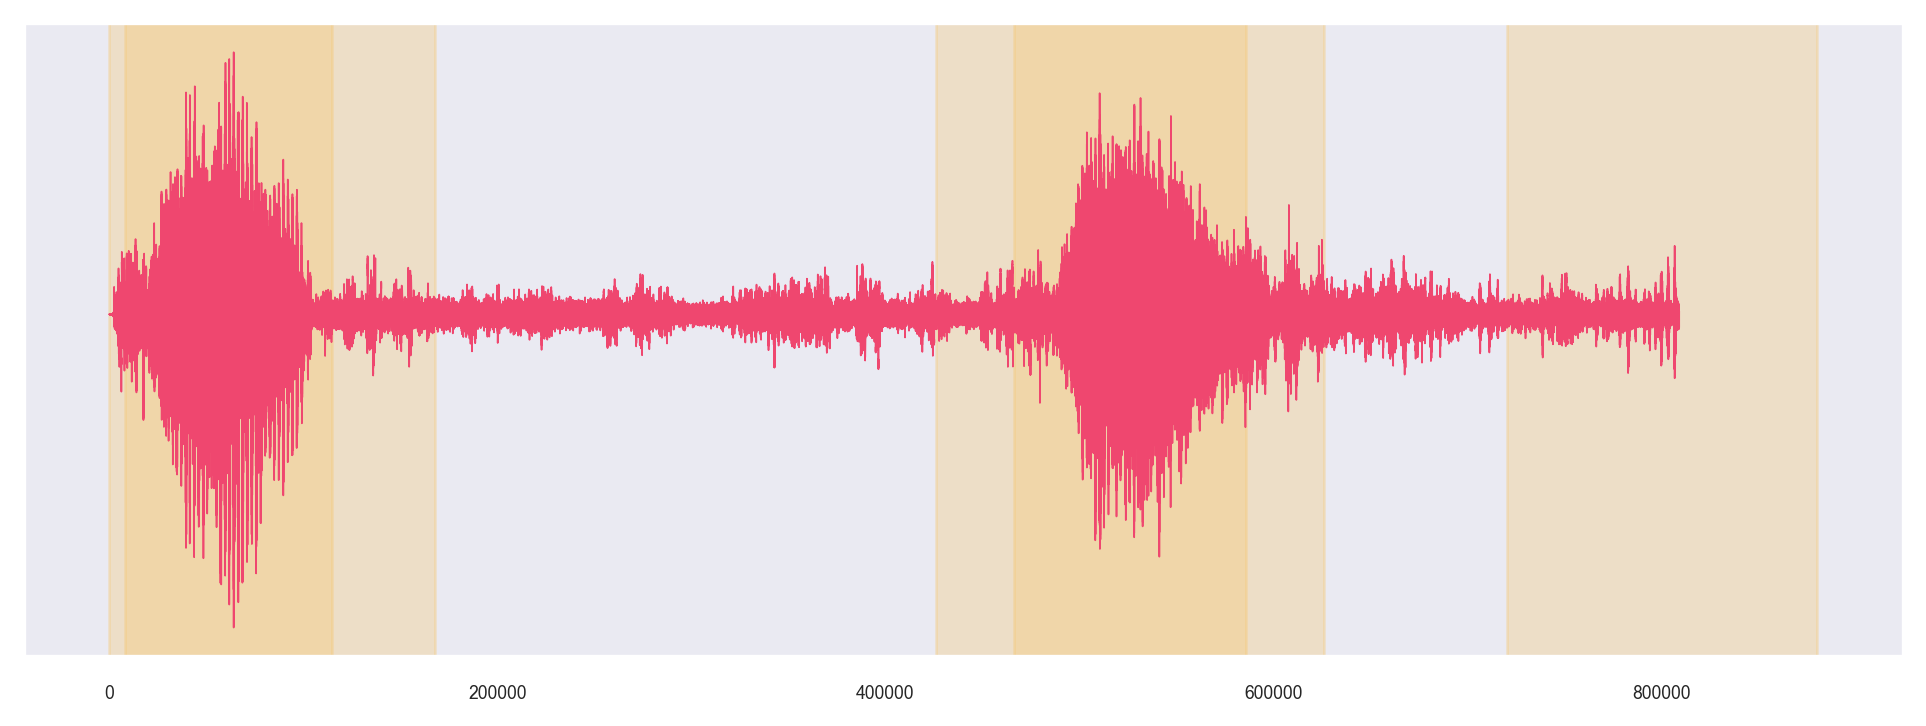

In [97]:
visualize_train_activity_detection(model_input_df=model_input_df, idx=None)

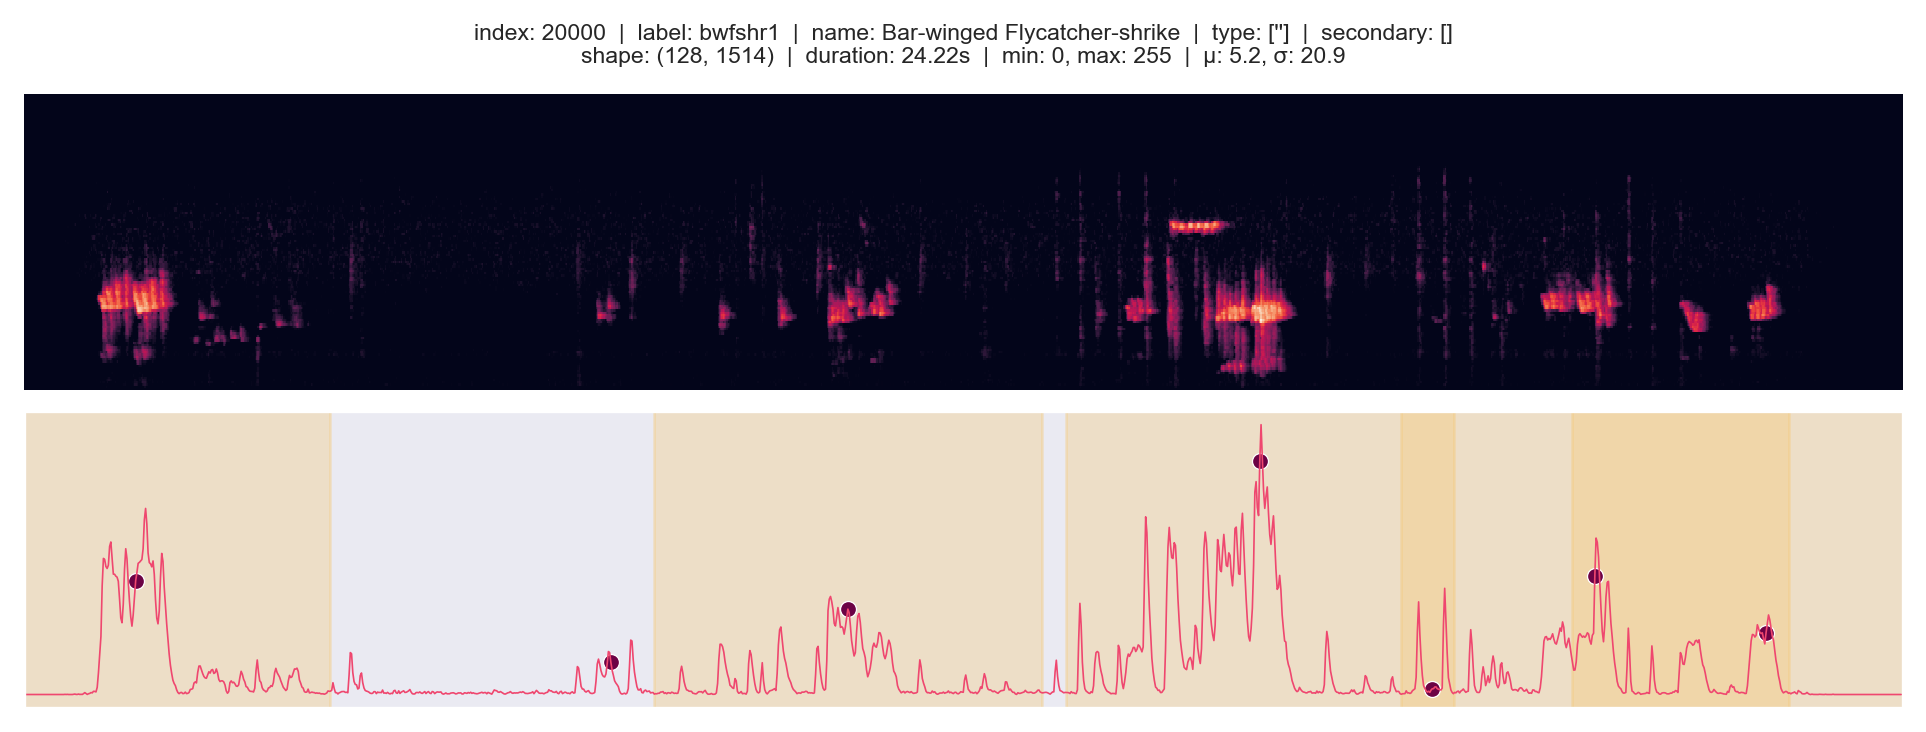

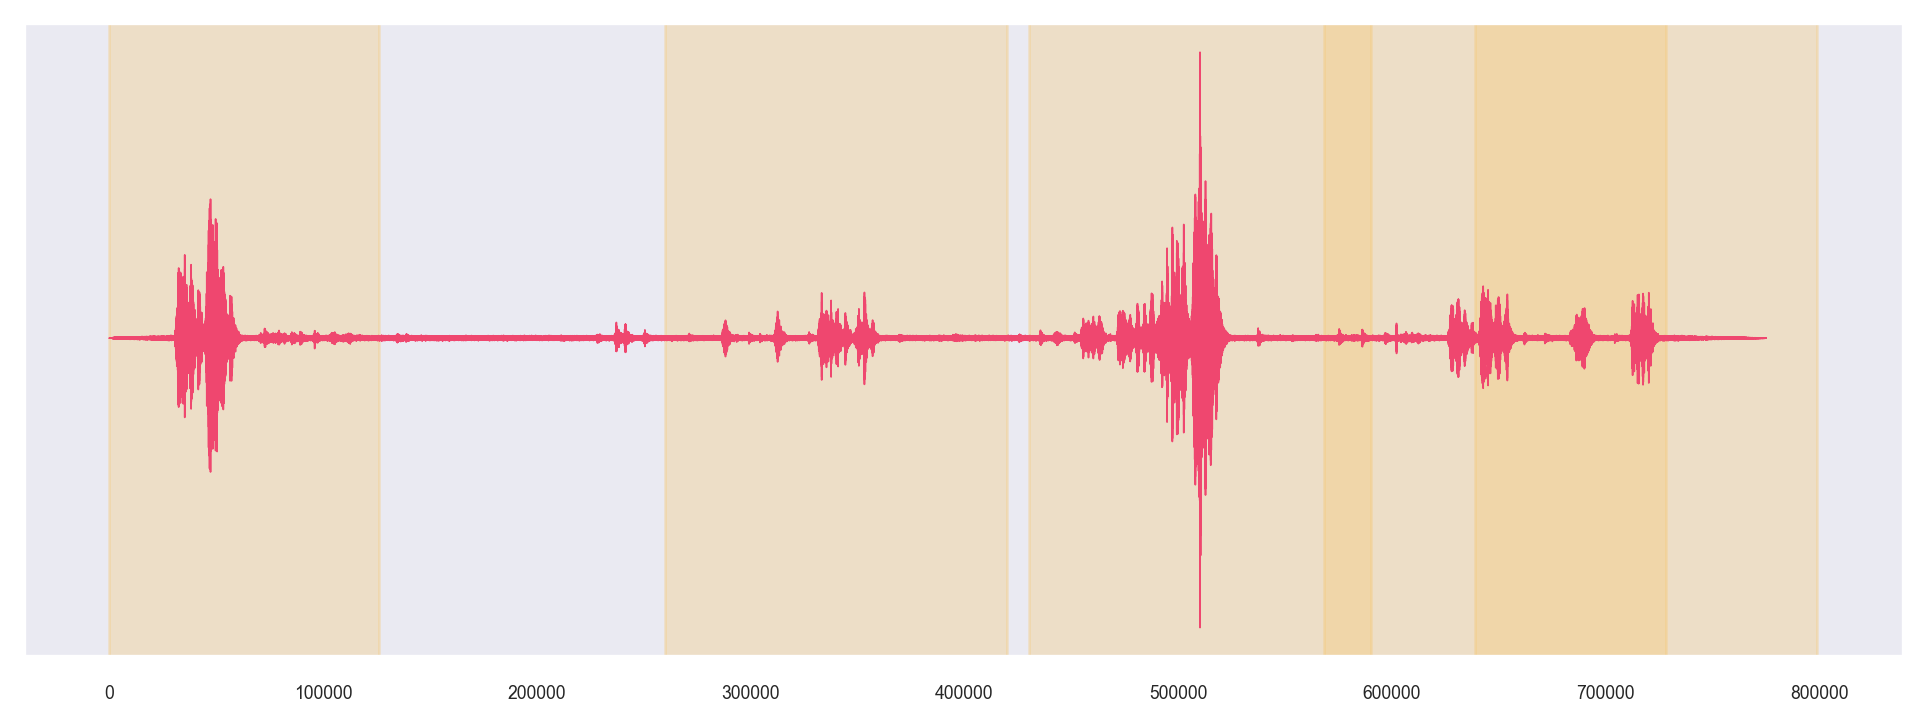

In [98]:
visualize_train_activity_detection(model_input_df=model_input_df, idx=None)

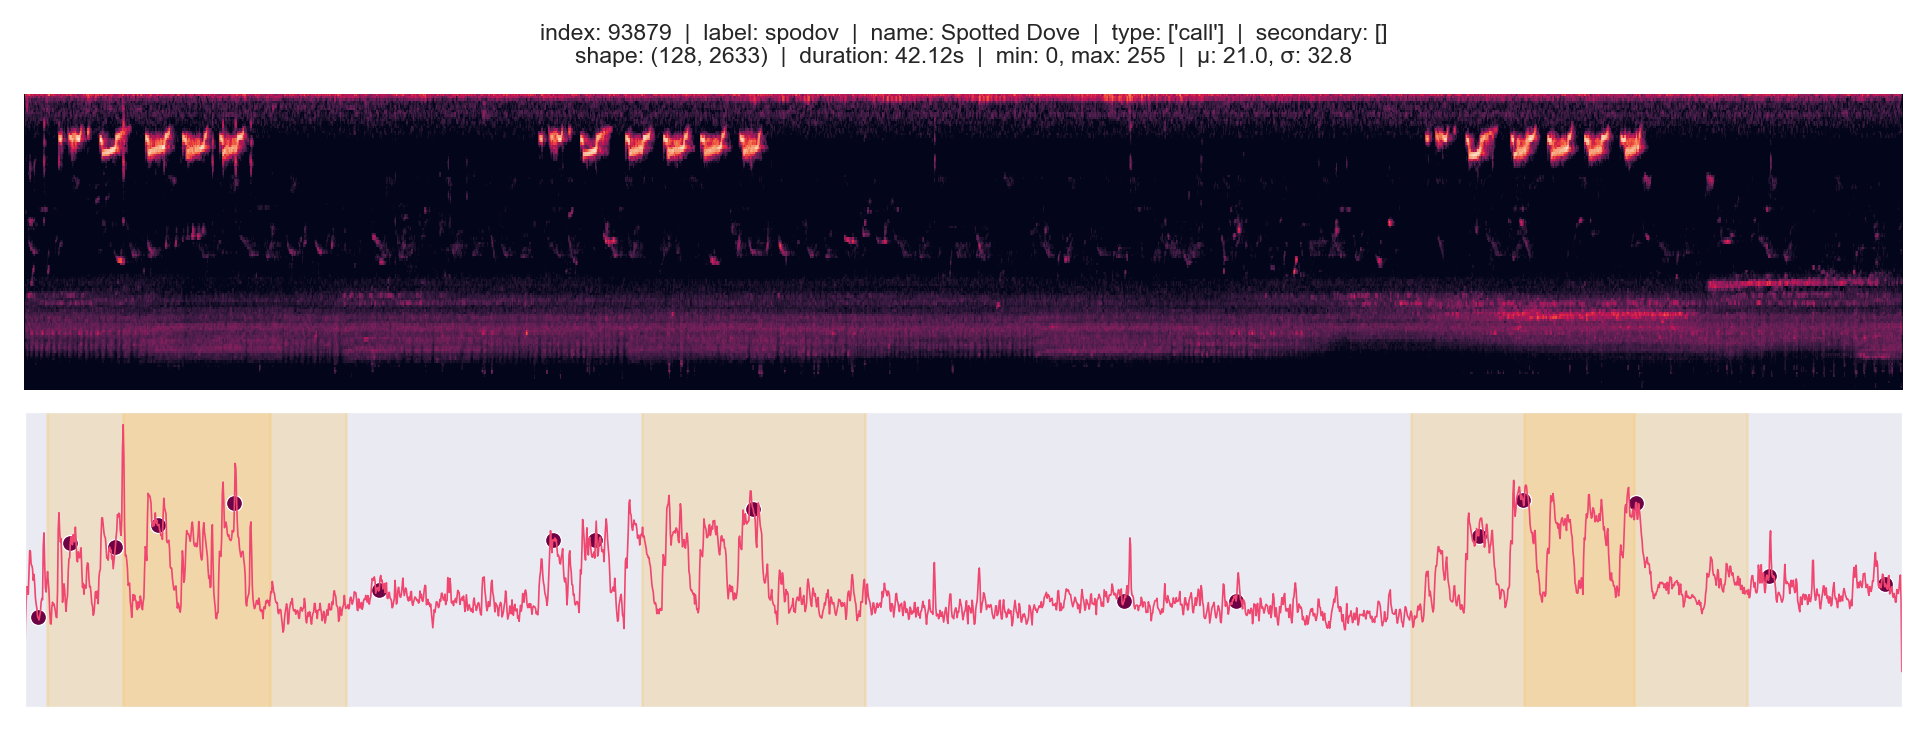

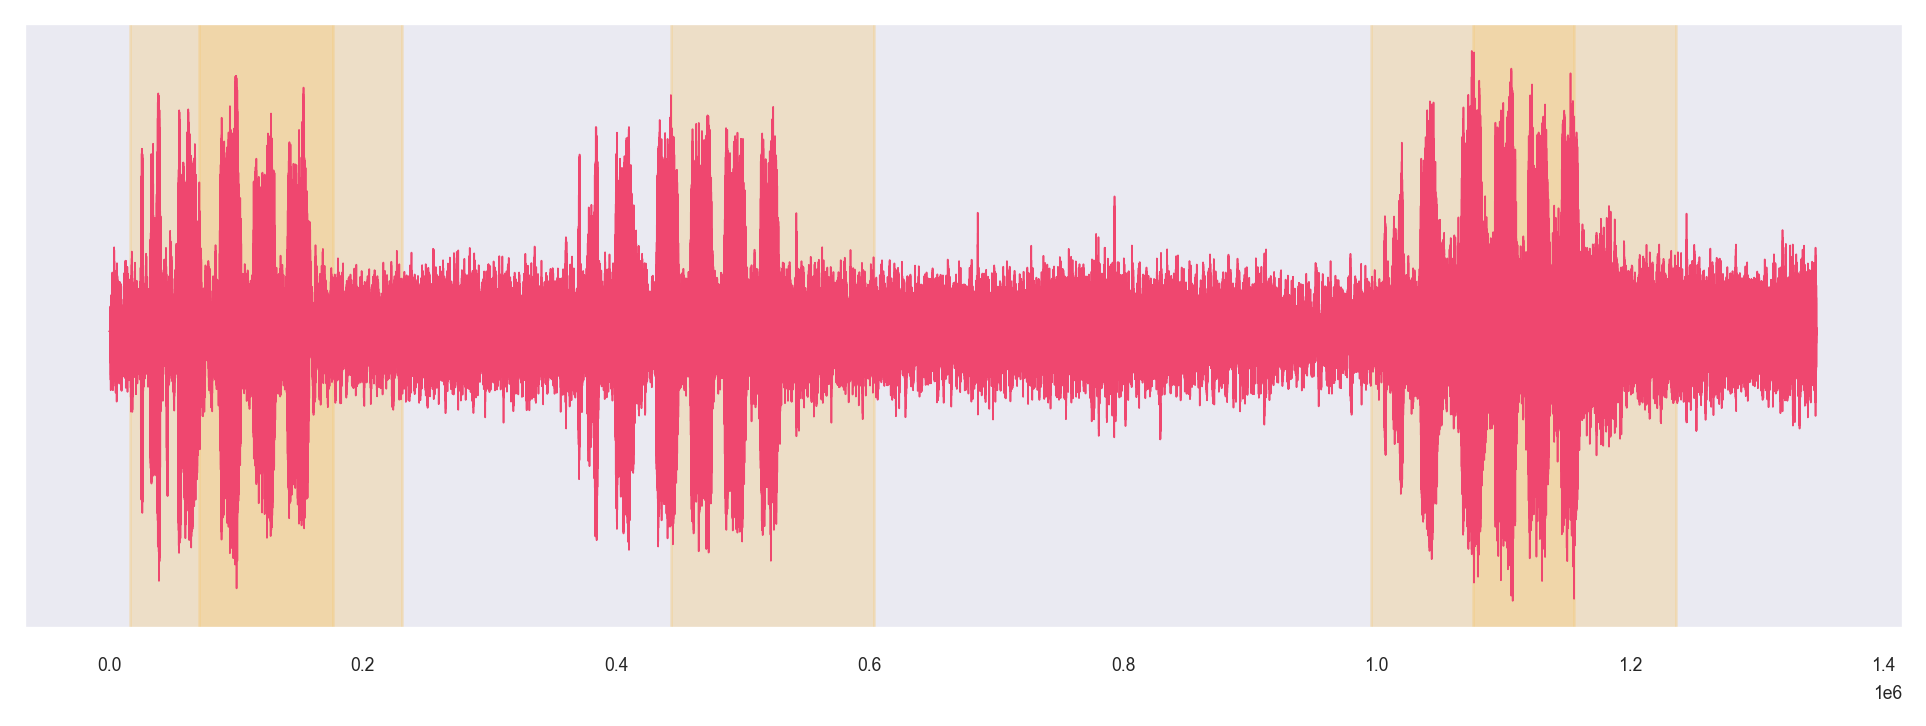

In [115]:
visualize_train_activity_detection(model_input_df=model_input_df, idx=None)

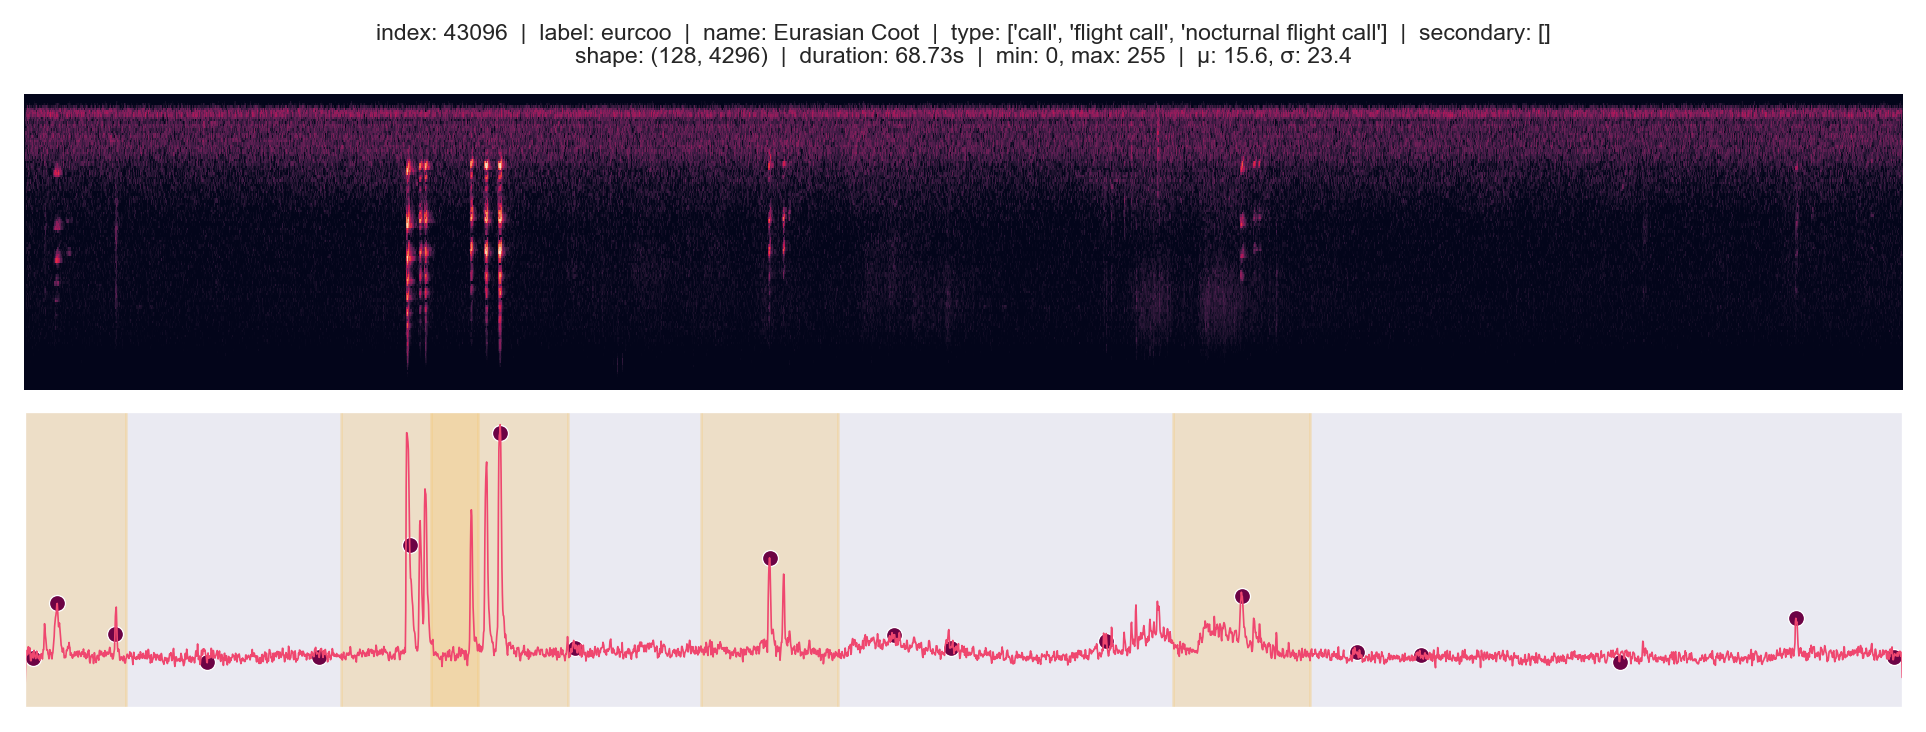

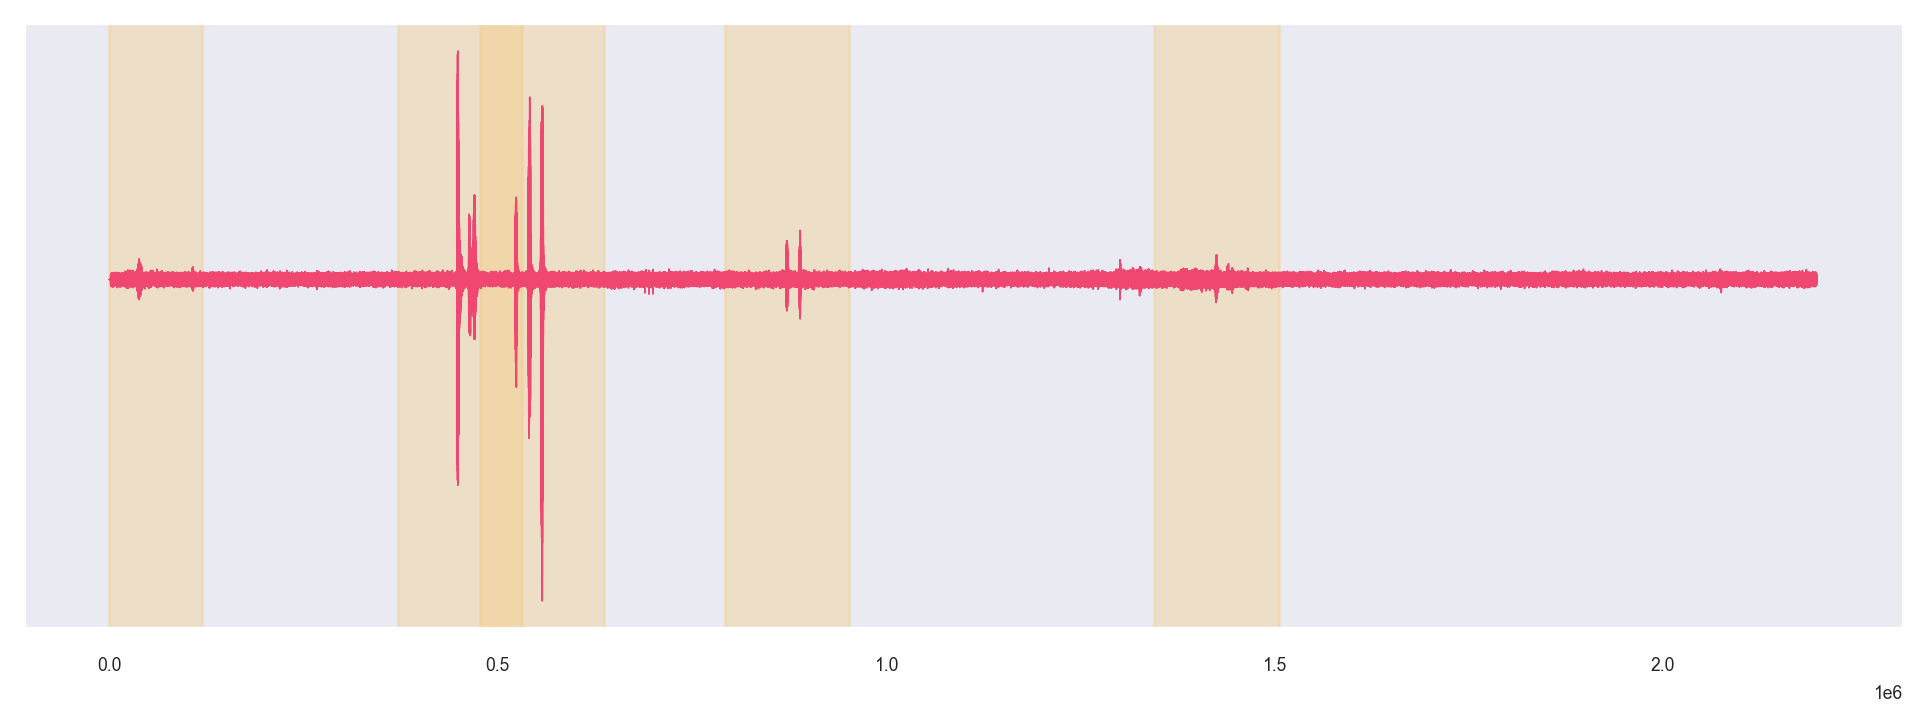

In [133]:
visualize_train_activity_detection(model_input_df=model_input_df, idx=None)

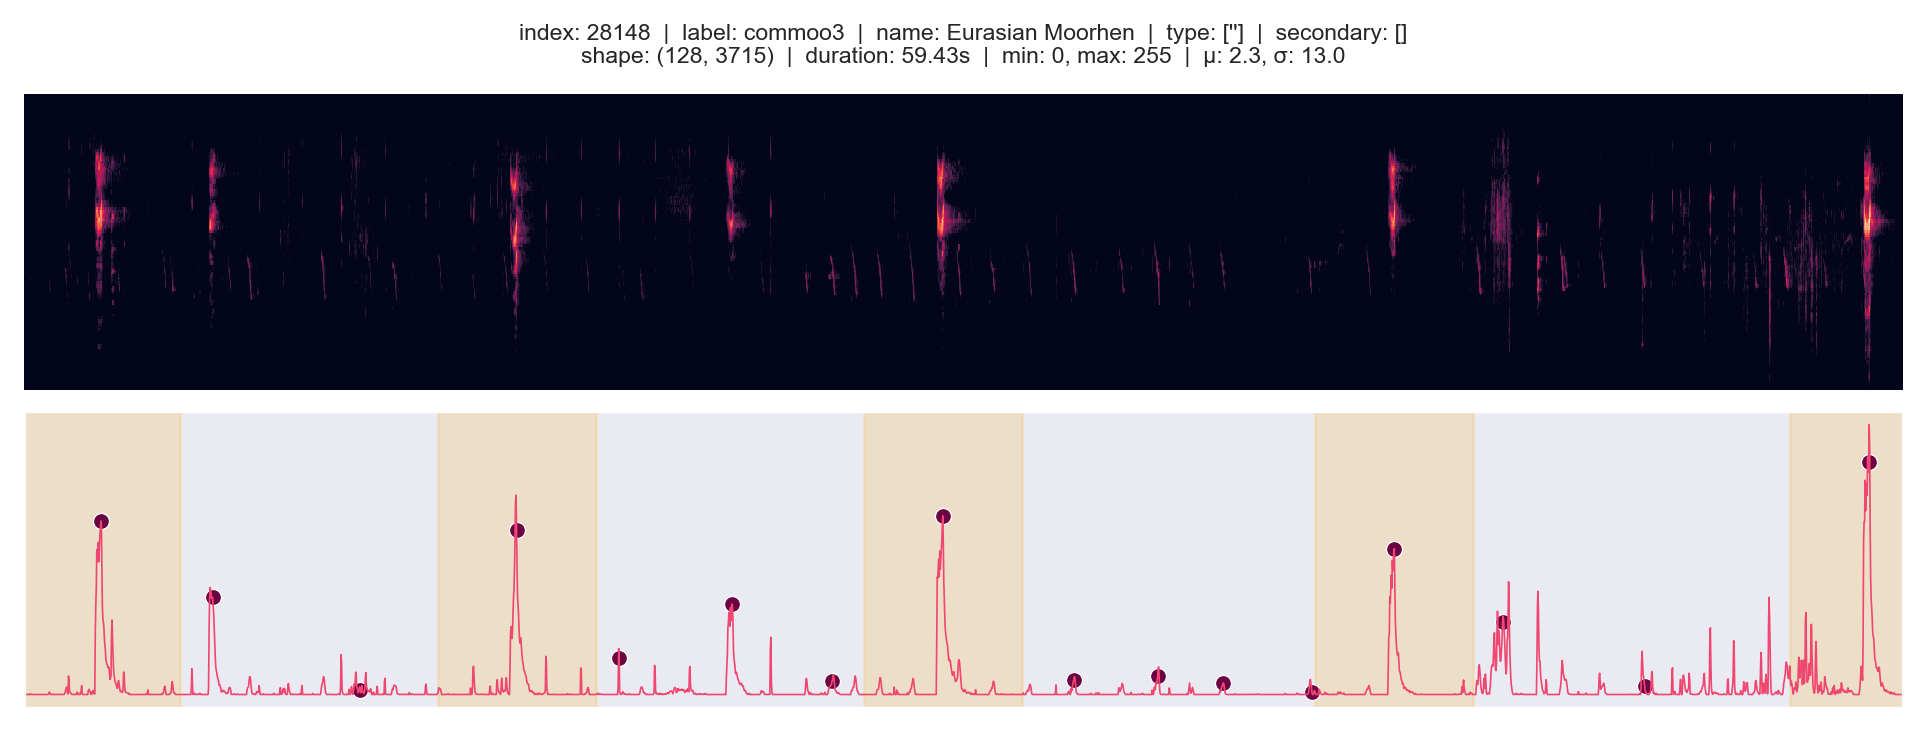

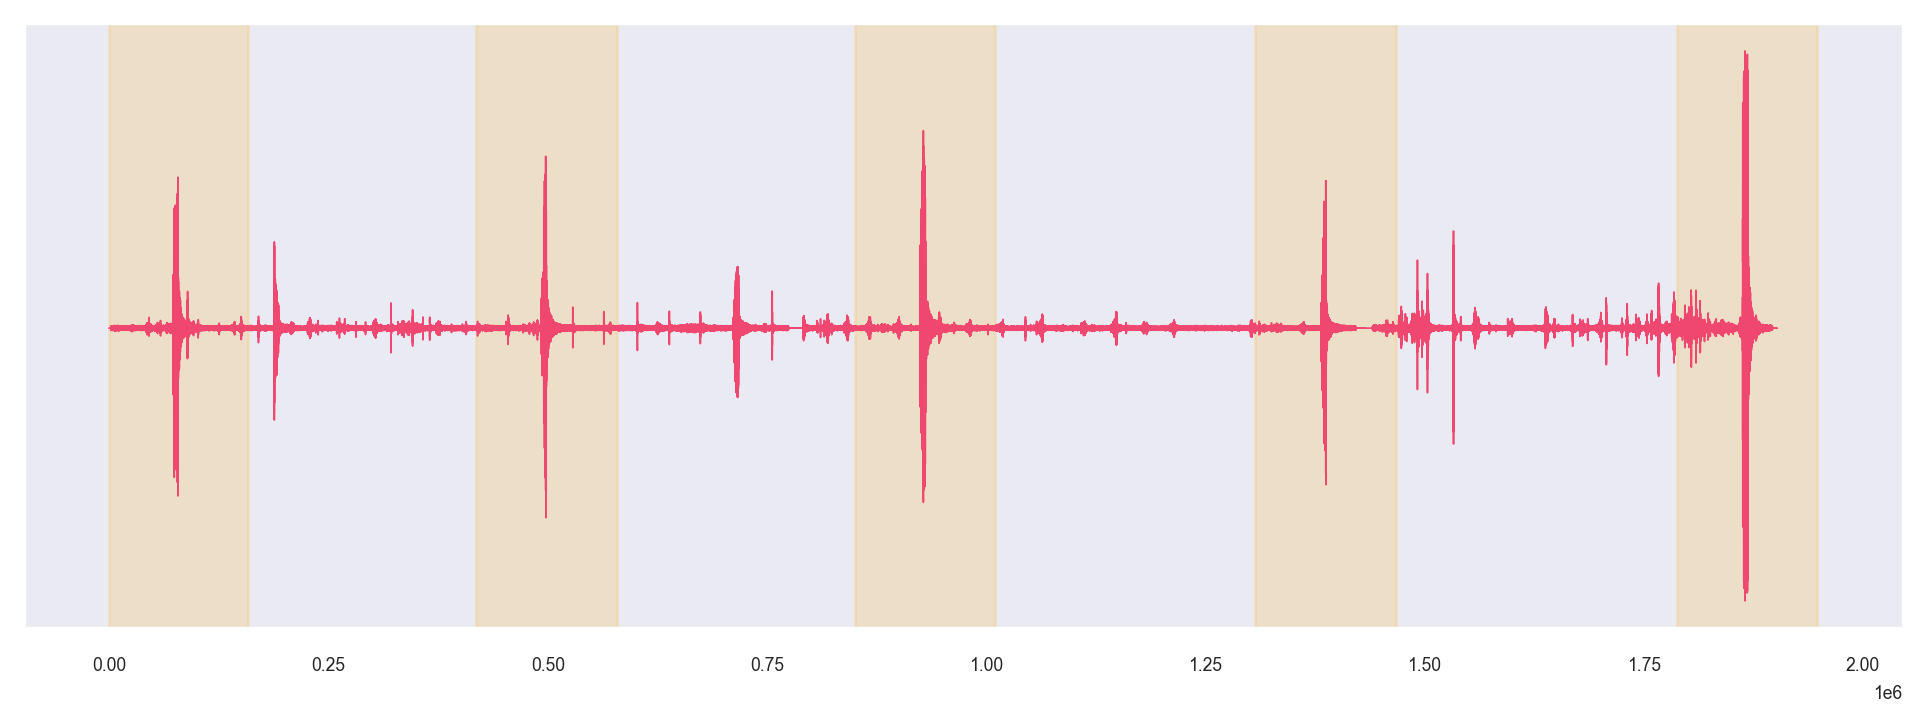

In [148]:
visualize_train_activity_detection(model_input_df=model_input_df, idx=None)

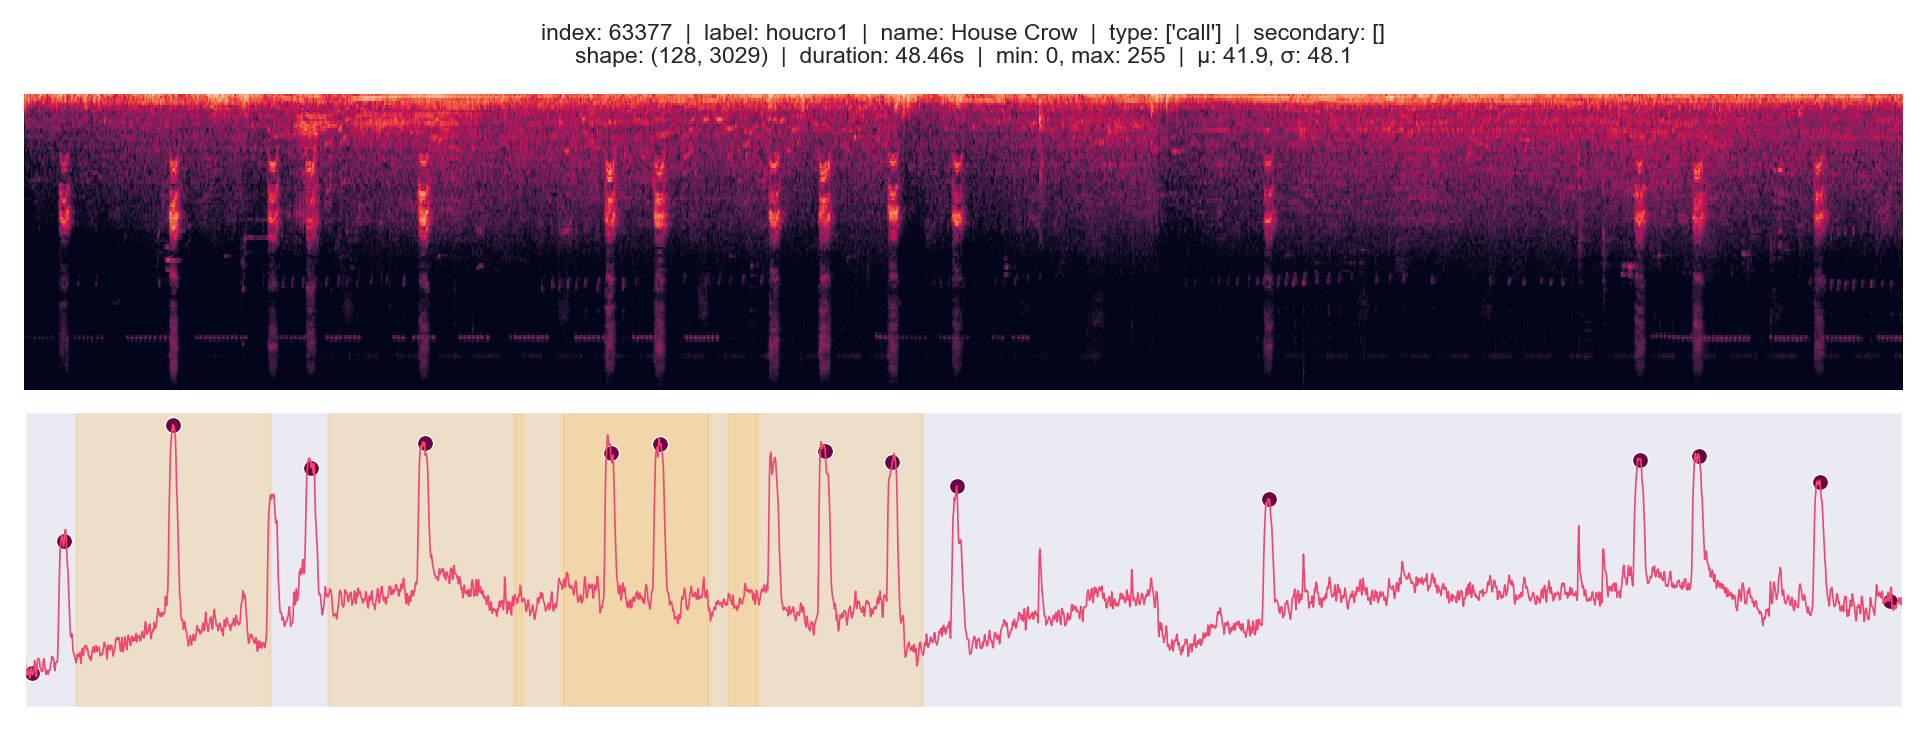

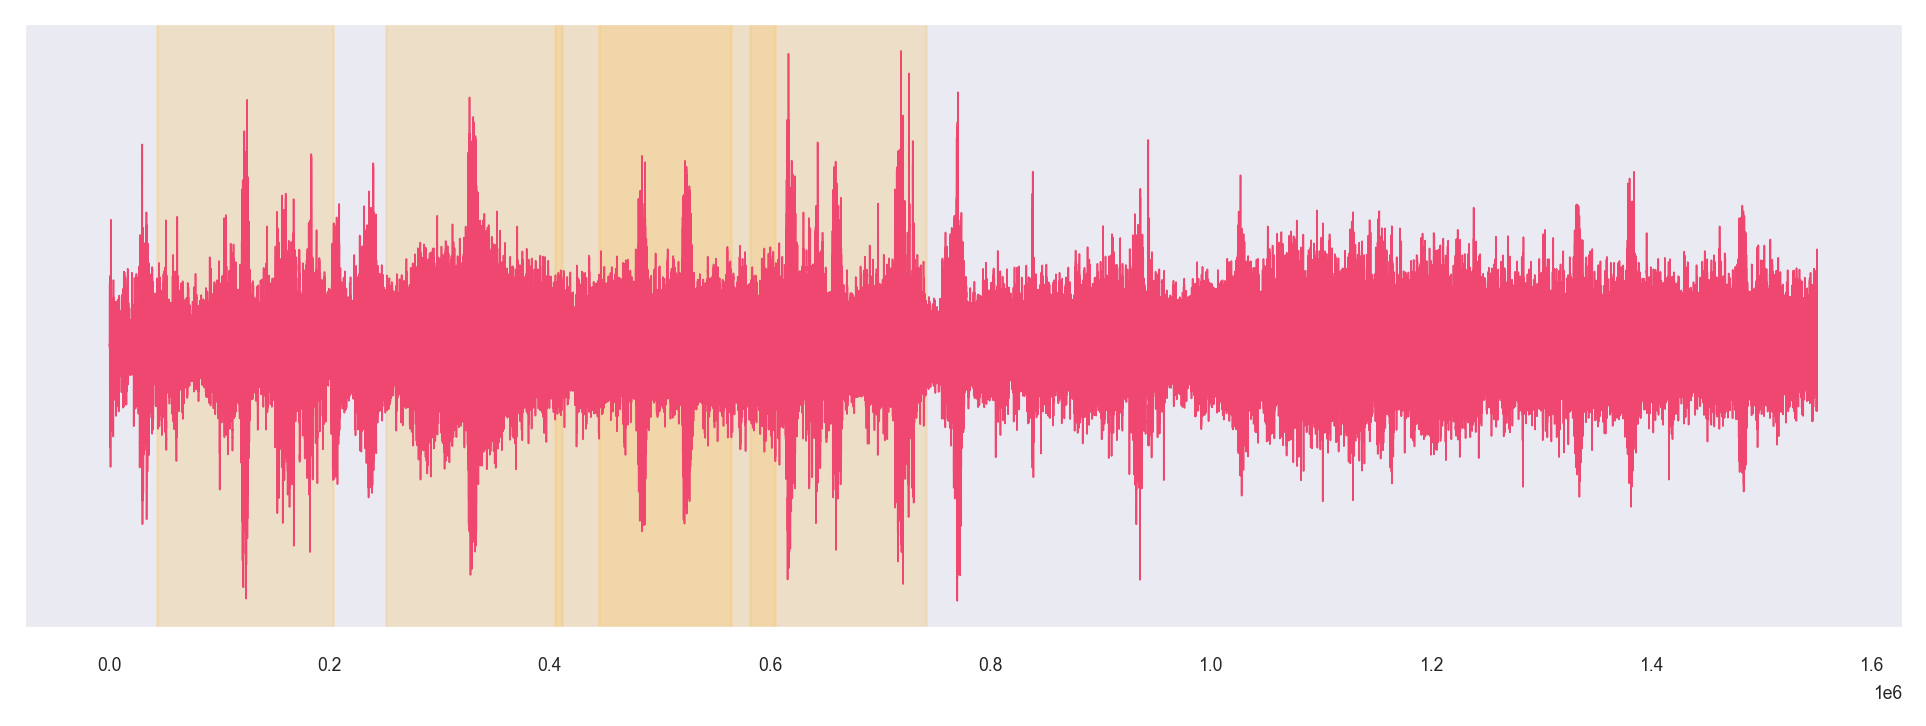

In [215]:
visualize_train_activity_detection(model_input_df=model_input_df, idx=None)